In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [69]:
def param_sweep_transfer_function_symmetry(params, param_name, param_values, f0=1000.0):
    """
    Sweeps one parameter and calculates transfer functions at a fixed frequency.
    """
    # Angular frequency
    omega = 2 * np.pi * f0
    if omega == 0:
        omega += 1e-9

    results = {
        "param_values": param_values,
        "abs_T_p": np.zeros_like(param_values, dtype=np.float64)
    }

    for i, val in enumerate(param_values):
        # Copy params and replace the swept parameter
        p = params.copy()
        p[param_name] = val

        # --- Extract parameters ---
        Rm, Ri, Cm = p['Rm'], p['Ri'], p['Cm']
        d, ds, l1, sym, s_in = p['d'], p['ds'], p['l1'], p['sym'], p['s_in']

        # --- Derived properties ---
        tau_m = Rm * Cm
        lambda_ = np.sqrt((d * Rm) / (4 * Ri))
        L1 = l1 / lambda_
        L2 = sym * L1
        W = omega * tau_m
        q = np.sqrt(1 + 1j * W)

        # Soma admittance
        Ys = np.pi * ds**2 * (1/Rm) * q**2

        # Infinite-stick admittance
        G_inf = np.pi * d**2 / (4 * Ri * lambda_)
        Y_inf = q * G_inf

        # Total admittance
        Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

        # Transfer function numerator/denominator
        numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
        denominator = Y_in_total

        T_p = numerator / denominator
        abs_T_p_squared = np.abs(T_p)**2

        results["abs_T_p"][i] = np.abs(T_p)

    return results


In [70]:
neuron_parameters_sym = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 um -> m
    'ds': 20e-6,        # 20 um -> m
    'l1': 0.67e-3,      # 0.67 mm -> m (Longer stick)
    'sym': 0.5,       
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

neuron_parameters = neuron_parameters_sym.copy()

# Vary dendrite diam
l_values = np.linspace(200e-6, 1000e-6, 100)
res_l_10 = param_sweep_transfer_function_symmetry(neuron_parameters, 'l1', l_values, f0=10)
res_l_1000 = param_sweep_transfer_function_symmetry(neuron_parameters, 'l1', l_values, f0=1000)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_33224/75265808.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("$|\mathbf{T}_p|$ at 10 Hz", color=color1,  size = 14)
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_33224/75265808.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel("$|\mathbf{T}_p|$ at 1000 Hz", color=color2, size = 14)


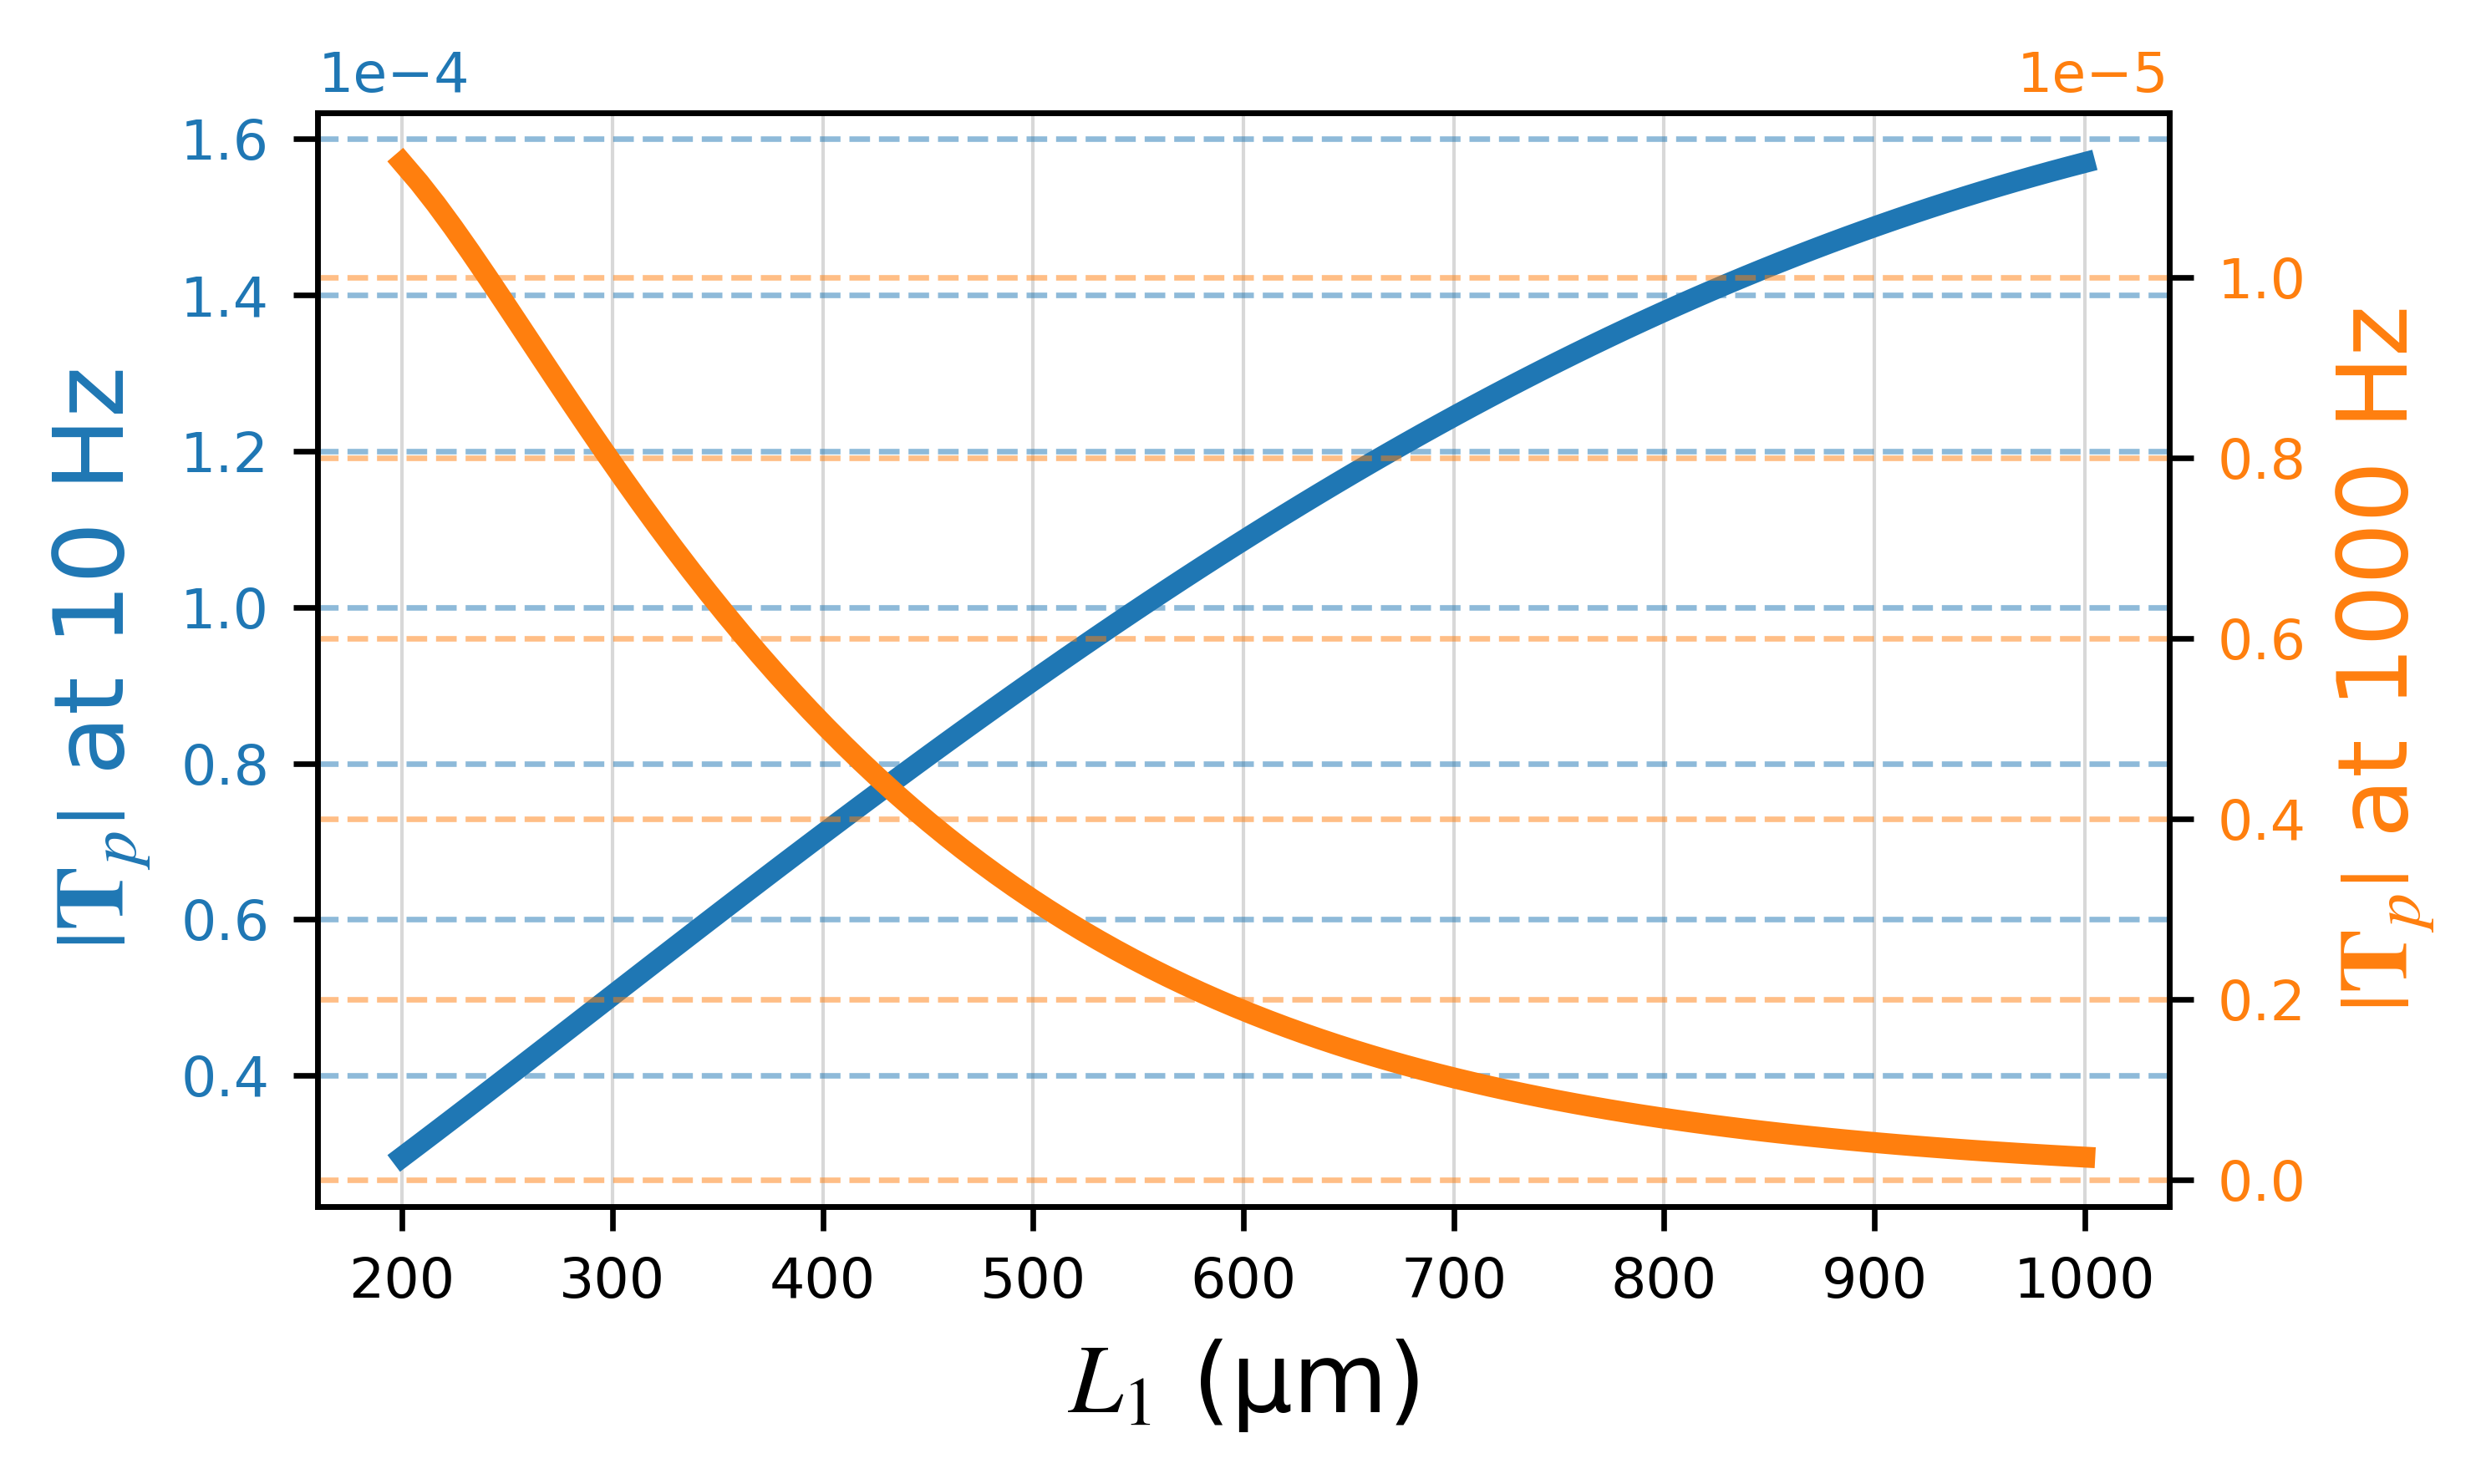

In [71]:
fig, ax1 = plt.subplots(figsize=(5, 3))
plt.rcParams['mathtext.fontset'] = 'stix'

# Use the data in micrometers (l_values * 1e6) for the x-axis
x_data = l_values * 1e6

# --- 2. Plotting on the Primary Y-Axis (ax1) for 10 Hz ---
color1 = 'tab:blue'
line1, = ax1.plot(x_data, res_l_10["abs_T_p"], color=color1, label="10 Hz", lw =3)
ax1.set_xlabel("$L_1$ (µm)", fontsize = 14)
ax1.set_ylabel("$|\mathbf{T}_p|$ at 10 Hz", color=color1,  size = 14)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.ticklabel_format(style = 'sci', scilimits=[-3,5])

#ax1.set_title("Transfer Function Magnitude vs. $L_1$ ($L_2 = 0.5*L_1$)")

# --- 3. Create Secondary Y-Axis (ax2) for 1000 Hz ---
# ax2 shares the same x-axis as ax1
ax2 = ax1.twinx()
color2 = 'tab:orange'
line2, = ax2.plot(x_data, res_l_1000["abs_T_p"], color=color2, label="1000 Hz", lw=3)
ax2.set_ylabel("$|\mathbf{T}_p|$ at 1000 Hz", color=color2, size = 14)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.ticklabel_format(style = 'sci', scilimits=[-3,5])

# lines = [line1, line2]
# labels = [l.get_label() for l in lines]
# ax1.legend(lines, labels, loc='center right', frameon=True)

# Apply grids. We apply the grid lines of ax1 and ax2 independently,
ax1.grid(which='both', axis='x', lw=0.5, color='gray', alpha=0.3, linestyle='-')
ax1.grid(which='both', axis='y', lw=0.8, color=color1, alpha=0.5, linestyle='--')
ax2.grid(which='both', axis='y', lw=0.8, color=color2, alpha=0.5, linestyle='--')

# Ensure layout is tight to prevent labels overlapping
fig.tight_layout()
plt.savefig('/Users/susannedahle/Documents/Master/Code/Plots_artikkel/transfer/tranfer_function_vs_len.png', dpi=300, bbox_inches='tight')